## Communication neuroscience on a shoestring

### Compliance Analysis

This script performs preprocessing steps as in the first notebook, but separates the data out according to sessions (1 and 2) and compliance-gaining condition (experimental group: 'request' vs. control group: 'control').

#### Import modules

In [1]:
import os, pickle, warnings, scipy.stats, mne, collections
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from utils import utils
from autoreject import get_rejection_threshold, AutoReject, compute_thresholds 

#### Load data into MNE objects

In [2]:
subjects             = list(np.load('../data/subjects.npy', allow_pickle=True))
compliance_condition = list(np.load('../data/compliance_condition.npy', allow_pickle=True))

sessions_to_import   = [1, 2]
results_drop_run     = []

for current_session in sessions_to_import:
    print('Current Session')
    print(current_session)
    print('--------------')

    stats_data = np.zeros(4)

    all_evokeds = []
    trials_res = []

    for curr_subject in subjects[:]:
        print("Current Subject #" + str(curr_subject))
        
        raw = utils.load_data('../data/Study_AB/', 
                              subject_nb = curr_subject, sfreq = 256., 
                              session_nb = current_session);

        raw.filter(0.1, 15, method='iir', verbose= False);

        events = mne.find_events(raw, min_duration=0, shortest_event = 0);
        event_id = {'Positive': 1, 'Neutral': 2};

        # Creating an Epoch object with standard parameters 
        epochs = mne.Epochs(raw, events = events, 
                        event_id = event_id, 
                        tmin = -0.1, tmax = 0.8, baseline = (-0.1,0),
                        detrend = 1, preload = True, verbose = False,
                        picks=[0,3]); 

        #Getting the automated rejection threshold for this file - otherwise same parameters as above
        print('------------ Autoreject: Get Threshold ------------')
        reject = get_rejection_threshold(epochs, decim=2)

        epochs = mne.Epochs(raw, events=events, 
                        event_id=event_id, 
                        tmin = -0.1, tmax = 0.8, baseline = (None, 0),
                        reject = reject, detrend = 1,preload=True,verbose=False,
                        picks=[0,3]);

        epochs.drop_bad(reject=reject)

        ar = AutoReject( n_interpolate= [0], random_state=42, n_jobs=1, verbose=False );
        epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
        stats_data[1] = np.round(epochs_ar['Neutral'].get_data().shape[0])
        stats_data[2] = np.round(epochs_ar['Positive'].get_data().shape[0])

        epochs_ar.drop_bad()
        sample_drop = (1 - len(epochs_ar.events)/len(events)) * 100
        stats_data[3] = sample_drop
        trials_res.append(stats_data.copy())

    results_drop_run.append(np.asarray(trials_res)[:,3])

Current Session
1
--------------
Current Subject #A-3
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
107 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #A-5
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
105 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #A-6
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
107 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #A-7
Creating RawArray with float64 data, n_channels=5, n_times=30552
    Range : 0 ... 30551 =      0.000 ...   119.340 secs


Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #B1-8
Creating RawArray with float64 data, n_channels=5, n_times=38100
    Range : 0 ... 38099 =      0.000 ...   148.824 secs
Ready.
120 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #B1-9
Creating RawArray with float64 data, n_channels=5, n_times=38088
    Range : 0 ... 38087 =      0.000 ...   148.777 secs
Ready.
120 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #B1-14
Creating RawArray with float64 data, n_channels=5, n_times=38256
    Range : 0 ... 38255 =      0.000 ...   149.434 secs
Ready.
120 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #B1-15
Creating RawArray with float64 data, n_

    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
107 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #A-21
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
108 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #A-22
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
108 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #A-23
Creating RawArray with float64 data, n_channels=5, n_times=30456
    Range : 0 ... 30455 =      0.000 ...   118.965 secs
Ready.
107 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection di

Current Subject #B1-30
Creating RawArray with float64 data, n_channels=5, n_times=38244
    Range : 0 ... 38243 =      0.000 ...   149.387 secs
Ready.
120 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #B1-31
Creating RawArray with float64 data, n_channels=5, n_times=38112
    Range : 0 ... 38111 =      0.000 ...   148.871 secs
Ready.
120 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #B1-32
Creating RawArray with float64 data, n_channels=5, n_times=38244
    Range : 0 ... 38243 =      0.000 ...   149.387 secs
Ready.
120 events found
Event IDs: [1 2]
------------ Autoreject: Get Threshold ------------
Estimating rejection dictionary for eeg
Current Subject #B1-33
Creating RawArray with float64 data, n_channels=5, n_times=38256
    Range : 0 ... 38255 =      0.000 ...   149.434 secs
Ready.
120 events found
E

In [15]:
drop_rate_df              = pd.DataFrame(np.asarray(results_drop_run).T, columns = ['session1', 'session2'], index = subjects)
drop_rate_df['condition'] = compliance_condition
drop_rate_df.to_csv('../data/drop_rate_results.csv')
drop_rate_df.head()

,session1,session2,condition
A-3,60.747664,80.373832,control
A-5,83.809524,89.622642,control
A-6,83.177570,49.532710,request
A-7,64.150943,42.452830,control
A-8,40.000000,41.121495,request


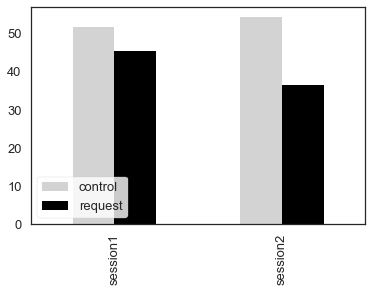

In [8]:
df = drop_rate_df.groupby(['condition']).mean().T
ax = df.plot(kind='bar', colors = ['lightgray', 'black']);
ax.legend(loc='lower left', frameon=True);

In [9]:
drop_rate_df.groupby(['condition']).mean()

,session1,session2
condition,,
control,51.650131,54.243550
request,45.375907,36.596732


In [10]:
drop_rate_df.groupby(['condition']).std()

,session1,session2
condition,,
control,18.173207,19.247774
request,24.152338,15.460780


In [11]:
scipy.stats.ttest_ind( drop_rate_df['session1'][drop_rate_df['condition']=='control'],
                       drop_rate_df['session1'][drop_rate_df['condition']=='request'])

Ttest_indResult(statistic=1.0029627818777203, pvalue=0.32124172456877)

In [12]:
scipy.stats.ttest_ind( drop_rate_df['session2'][drop_rate_df['condition']=='control'],
                       drop_rate_df['session2'][drop_rate_df['condition']=='request'])

Ttest_indResult(statistic=3.4725925986121684, pvalue=0.0011504516846443055)

In [13]:
scipy.stats.ttest_rel( drop_rate_df['session1'][drop_rate_df['condition']=='control'],
                       drop_rate_df['session2'][drop_rate_df['condition']=='control'])

Ttest_relResult(statistic=-0.6229371322790952, pvalue=0.5397303018553377)

In [14]:
scipy.stats.ttest_rel( drop_rate_df['session1'][drop_rate_df['condition']=='request'],
                       drop_rate_df['session2'][drop_rate_df['condition']=='request'])

Ttest_relResult(statistic=2.109163101351896, pvalue=0.0460236720522602)